In [62]:
from qiskit import Aer, QuantumCircuit, transpile, execute
from qiskit.circuit import Parameter
import numpy as np
from scipy.optimize import minimize

In [63]:
from qiskit import Aer, QuantumCircuit, transpile, execute
import numpy as np

# Step 1: Define the QCBM Circuit
def qcbm_circuit(params, num_qubits, num_layers=2):
    """
    Construct a QCBM circuit with the specified number of layers (d).
    
    Args:
        params (np.ndarray): Array of parameters (size: num_qubits * 3 * num_layers).
        num_qubits (int): Number of qubits.
        num_layers (int): Number of layers (d).
        
    Returns:
        QuantumCircuit: The parameterized QCBM circuit.
    """
    qc = QuantumCircuit(num_qubits)
    idx = 0

    for layer in range(num_layers):
        # Single-qubit rotations for each qubit in the layer
        for q in range(num_qubits):
            qc.rz(params[idx], q)
            qc.rx(params[idx + 1], q)
            qc.rz(params[idx + 2], q)
            idx += 3
        # Add entangling gates
        for q in range(num_qubits - 1):
            qc.cx(q, q + 1)
    return qc


In [64]:
# Step 2: Define the Loss Function
def loss_function(params, num_qubits, num_layers, target_distribution):
    """
    Calculate the KL divergence between target and generated distributions.
    
    Args:
        params (np.ndarray): Current parameters of the QCBM circuit.
        num_qubits (int): Number of qubits.
        num_layers (int): Number of layers (d).
        target_distribution (dict): Target probability distribution.
        
    Returns:
        float: KL divergence.
    """
    qc = qcbm_circuit(params, num_qubits, num_layers)
    qc.measure_all()

    # Simulate the circuit
    simulator = Aer.get_backend('qasm_simulator')
    qc = transpile(qc, simulator)
    result = execute(qc, backend=simulator, shots=1000).result()
    counts = result.get_counts()
    
    # Convert counts to probabilities
    generated_distribution = {k: v / 1000 for k, v in counts.items()}
    
    # Calculate KL divergence
    kl_divergence = 0
    for bitstring, target_prob in target_distribution.items():
        generated_prob = generated_distribution.get(bitstring, 1e-10)
        kl_divergence += target_prob * np.log(target_prob / generated_prob)
    
    return kl_divergence


In [65]:
def gradient_computer(params,params_shift,num_qubits,  num_layers, target_distribution):
    qc_a = qcbm_circuit(params, num_qubits, num_layers)
    qc_a.measure_all()

    simulator = Aer.get_backend('qasm_simulator')
    qc_a = transpile(qc_a, simulator)
    result_a = execute(qc_a, backend=simulator, shots=1000).result()
    counts_a = result_a.get_counts()
    
    # Normalize counts to probabilities
    generated_distribution_a = {k: v / 1000 for k, v in counts_a.items()}
    
    qc_b = qcbm_circuit(params_shift, num_qubits, num_layers)
    qc_b.measure_all()

    simulator = Aer.get_backend('qasm_simulator')
    qc_b = transpile(qc_b, simulator)
    result_b = execute(qc_b, backend=simulator, shots=1000).result()
    counts_b = result_b.get_counts()

    # Normalize counts to probabilities
    generated_distribution_b = {k: v / 1000 for k, v in counts_b.items()}
    
    gradient_component=0
    for bitstring, target_prob in target_distribution.items():
        generated_prob_a = generated_distribution_a.get(bitstring, 1e-10)
        generated_prob_b = generated_distribution_b.get(bitstring, 1e-10)
        gradient_component -=  target_prob /generated_prob_a*generated_prob_b
        
    return gradient_component

In [66]:

# Step 3: Define the Gradient Computation
def compute_gradients(params, num_qubits, num_layers, target_distribution):
    """
    Compute gradients of the loss function using the parameter-shift rule.
    
    Args:
        params (np.ndarray): Current parameters of the QCBM circuit.
        num_qubits (int): Number of qubits.
        num_layers (int): Number of layers (d).
        target_distribution (dict): Target probability distribution.
        
    Returns:
        np.ndarray: Gradients of the loss function w.r.t. parameters.
    """
    gradients = np.zeros_like(params)
    shift = np.pi / 2  # Parameter shift value

    for i in range(len(params)):
        # Shift parameter up
        params_shifted_up = np.copy(params)
        params_shifted_up[i] += shift
        loss_up = gradient_computer(params, params_shifted_up, num_qubits, num_layers, target_distribution)

        # Shift parameter down
        params_shifted_down = np.copy(params)
        params_shifted_down[i] -= shift
        loss_down = gradient_computer(params, params_shifted_down, num_qubits, num_layers, target_distribution)

        # Compute gradient
        gradients[i] =loss_up - loss_down

    return gradients

In [67]:
# Step 4: Gradient Descent Training
def gradient_descent(initial_params, num_qubits, num_layers, target_distribution, learning_rate=0.1, max_iters=100):
    """
    Perform gradient descent to optimize QCBM parameters.
    
    Args:
        initial_params (np.ndarray): Initial QCBM parameters.
        num_qubits (int): Number of qubits.
        num_layers (int): Number of layers (d).
        target_distribution (dict): Target probability distribution.
        learning_rate (float): Learning rate for parameter updates.
        max_iters (int): Maximum number of iterations.
        
    Returns:
        np.ndarray: Optimized parameters.
    """
    params = np.copy(initial_params)
    for iteration in range(max_iters):
        # Compute gradients
        gradients = compute_gradients(params, num_qubits, num_layers, target_distribution)
        
        # Update parameters
        params -= learning_rate * gradients
        
        # Compute loss for monitoring
        loss = loss_function(params, num_qubits, num_layers, target_distribution)
        print(f"Iteration {iteration + 1}, Loss: {loss}")
    
    return params


In [72]:
# Step 5: Train the QCBM
num_qubits = 3
num_layers = 2
num_params = num_qubits * 3 * num_layers
initial_params = np.random.uniform(0, 2 * np.pi, num_params)

# Define target distribution (e.g., |110⟩ with 0.8 probability, |001⟩ with 0.2 probability)
target_distribution = {'110': 0.8, '001': 0.2}

# Train using gradient descent
optimized_params = gradient_descent(
    initial_params, 
    num_qubits, 
    num_layers, 
    target_distribution, 
    learning_rate=0.1, 
    max_iters=100
)


Iteration 1, Loss: 1.9415229924727635
Iteration 2, Loss: 1.3054054737197744
Iteration 3, Loss: 1.109682775887949
Iteration 4, Loss: 0.8031387252329656
Iteration 5, Loss: 0.6056858567546796
Iteration 6, Loss: 0.5544272137634899
Iteration 7, Loss: 0.447875797917038
Iteration 8, Loss: 0.32435771789580237
Iteration 9, Loss: 0.3201577083638559
Iteration 10, Loss: 0.26707622613666704
Iteration 11, Loss: 0.22258858364400114
Iteration 12, Loss: 0.20214335129178537
Iteration 13, Loss: 0.18032355413128148
Iteration 14, Loss: 0.12754489176157935
Iteration 15, Loss: 0.11073409123014828
Iteration 16, Loss: 0.0999971921397482
Iteration 17, Loss: 0.0971676974552826
Iteration 18, Loss: 0.07612853256215067
Iteration 19, Loss: 0.06310674067688672
Iteration 20, Loss: 0.06364224314180941
Iteration 21, Loss: 0.053656823226536074
Iteration 22, Loss: 0.05669437850691494
Iteration 23, Loss: 0.033102410501526736
Iteration 24, Loss: 0.03788295710677623
Iteration 25, Loss: 0.03700497334624307
Iteration 26, Loss:

In [70]:
# Step 6: Generate Samples Using Trained QCBM
trained_qcbm = qcbm_circuit(optimized_params, num_qubits, num_layers)
trained_qcbm.measure_all()

simulator = Aer.get_backend('qasm_simulator')
trained_qcbm = transpile(trained_qcbm, simulator)
result = execute(trained_qcbm, backend=simulator, shots=1000).result()
counts = result.get_counts()

print("Generated Distribution:", counts)


Generated Distribution: {'001': 205, '110': 795}


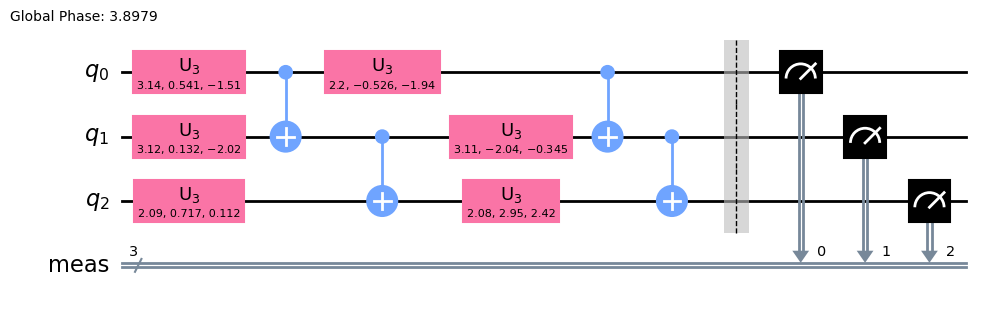

In [58]:
trained_qcbm.draw(output="mpl")

In [59]:
num_qubits = 3
num_layers = 2
num_params = num_qubits * 3 * num_layers
initial_params = np.random.uniform(0, 2 * np.pi, num_params)

# Define target distribution (e.g., |110⟩ with 0.8 probability, |001⟩ with 0.2 probability)
target_distribution = {'110': 0.8, '001': 0.2}

result_cob = minimize(loss_function, initial_params, args=(num_qubits,num_layers, target_distribution), method='COBYLA')

# Optimized parameters
optimized_params_cob = result_cob.x

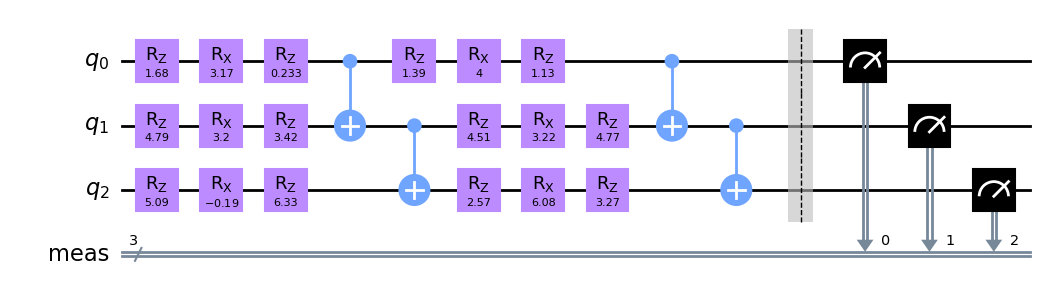

In [60]:
trained_qcbm_cob = qcbm_circuit(optimized_params_cob, num_qubits, num_layers)
trained_qcbm_cob.measure_all()
trained_qcbm_cob.draw(output="mpl")

In [61]:
simulator = Aer.get_backend('qasm_simulator')
trained_qcbm = transpile(trained_qcbm_cob, simulator)
result = execute(trained_qcbm_cob, backend=simulator, shots=1000).result()
counts = result.get_counts()

print("Generated Distribution:", counts)

Generated Distribution: {'100': 1, '110': 815, '001': 177, '101': 2, '000': 1, '010': 4}
